In [ ]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [ ]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

     |████████████████████████████████| 164.6MB 84kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.2-py2.py3-none-any.whl size=164620456 sha256=c32f6e27282ef6d9ae33b6595251b75d2190e73e92f92646a754196986b0dd3e
  Stored in directory: /root/.cache/pip/wheels/42/bd/ea/218fd15724eddf6fa7fc8fab802b6fa592e623d87199679721
Successfully built h2o


In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline
sns.set(style="white",context="talk")

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 1. Data Preview

In [ ]:
# Load the conversion project dataset
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/A collection of data challenge/1. Conversion Rate/conversion_project.csv", sep=",")

# Let us first develop a preview of the conversion dataset
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [ ]:
# Exploring the data types, number of unique values and missing values
print(f"The conversion dataset consists of {data.shape[0]} rows and {data.shape[1]} columns, with no missing values \n")
pd.DataFrame({"data_types":data.dtypes, 
          "value_counts": data.nunique(),
          "null_counts": data.isnull().sum()}).set_index(data.dtypes.index)

The conversion dataset consists of 316200 rows and 6 columns, with no missing values 



,data_types,value_counts,null_counts
country,object,4,0
age,int64,60,0
new_user,int64,2,0
source,object,3,0
total_pages_visited,int64,29,0
converted,int64,2,0


In [ ]:
# Next, let's take a look at the descriptive statistics
print("For numeric variables: \n",data.describe(),"\n")
print("For categorical variables: \n", data.describe(include = "object"))

For numeric variables: 
                  age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000 

For categorical variables: 
        country  source
count   316200  316200
unique       4       3
top         US     Seo
freq    178092  155040


# 2. Data Cleaning
Since "new_user" and "convered" are essentially label columns with only 2 unique values of 1 and 0. Here I focus on removing outliers within "age" and "total_pages_visited" columns

Despite the fact that the total_pages_visited column does contain a few outliers (beyond the 75% percentile + 1.5*IQR),they are not mistakes because they come from user loggings;
While the self reported age values consists of two prominant outliers that are apparently erroneous, so we remove them



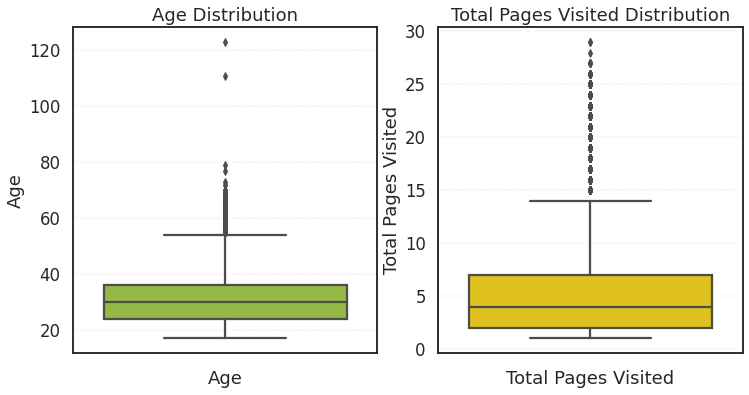

In [ ]:
# Create the axes and figure 
# Prepare for spaces for the "age", "total_pages_visited" columns
f, axes = plt.subplots(1, 2, figsize = (12,6)) 

# Create the boxplots. Assign the ax keyword argument
sns.boxplot(data = data.age ,ax=axes[0], color = "yellowgreen")
sns.boxplot(data = data.total_pages_visited, ax= axes[1], color = "gold")

axes[0].set_title("Age Distribution")
axes[0].set_ylabel("Age")
axes[0].set_xlabel("Age")
axes[0].set_xticklabels("")
axes[0].grid(axis = "y", linestyle="--", alpha=0.2)

axes[1].set_title("Total Pages Visited Distribution")
axes[1].set_ylabel("Total Pages Visited")
axes[1].set_xlabel("Total Pages Visited")
axes[1].set_xticklabels("")
axes[1].grid(axis = "y", linestyle="--", alpha=0.2)

print("Despite the fact that the total_pages_visited column does contain a few outliers (beyond the 75% percentile + 1.5*IQR),they are not mistakes because they come from user loggings;\n\
While the self reported age values consists of two prominant outliers that are apparently erroneous, so we remove them\n")
data = data[data.age<100]

In [ ]:
def get_outliers_count(df,col_name):

  Q1 = df[col_name].quantile(0.25)
  Q3 = df[col_name].quantile(0.75)
  IQR = Q3 - Q1
  outliers = (df[col_name] < (Q1 - 1.5 * IQR)) | (df[col_name] > (Q3 + 1.5 * IQR))
  print(f"{col_name}: the maximum cutoff is {Q3+1.5*IQR}, the minimum cutoff is {Q1-1.5*IQR}, total number of outliers is: {outliers.sum()}")


get_outliers_count(data,"age")
get_outliers_count(data,"total_pages_visited")

age: the maximum cutoff is 54.0, the minimum cutoff is 6.0, total number of outliers is: 1548
total_pages_visited: the maximum cutoff is 14.5, the minimum cutoff is -5.5, total number of outliers is: 5662


# 3. Exploratory Data Analysis

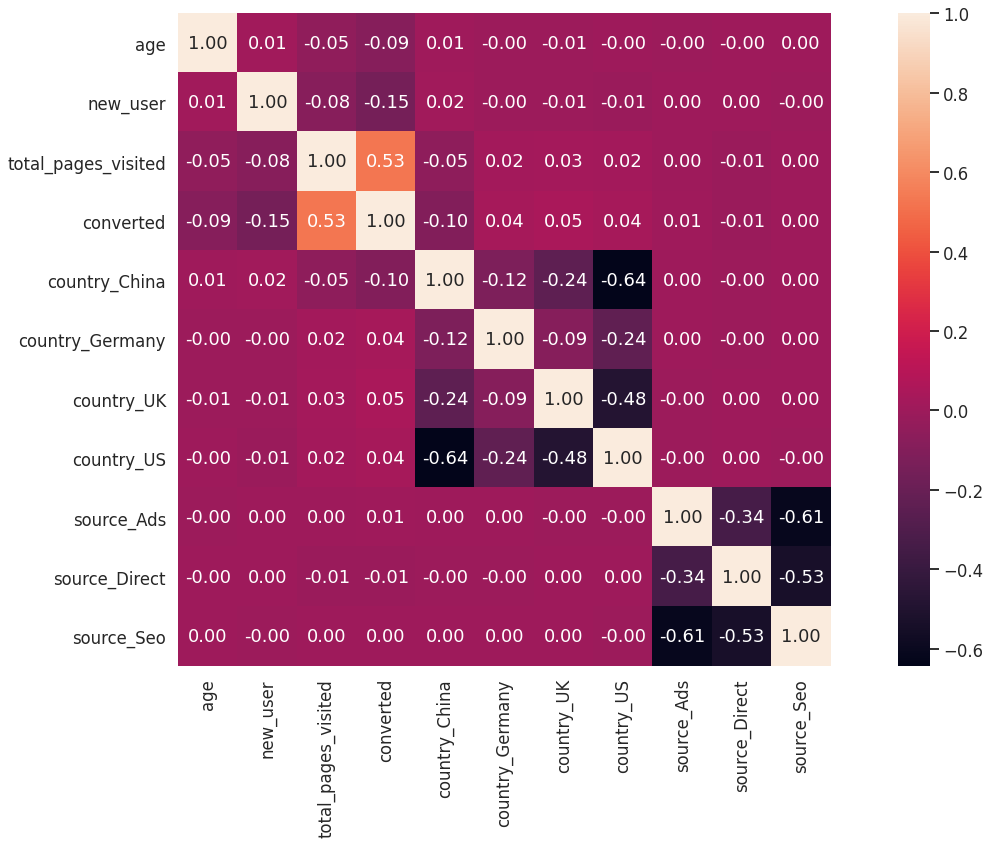

In [ ]:
# Multi-variate analysis
corr_data = pd.get_dummies(data).corr()
plt.subplots(figsize=(24,12))
sns.heatmap(corr_data, annot=True, vmax=1, square=True, fmt='.2f')
plt.show()


In [ ]:
# 	Correlation with the target variable
corr_data["converted"].sort_values()

new_user              -0.152338
country_China         -0.098961
age                   -0.089199
source_Direct         -0.012596
source_Seo             0.003534
source_Ads             0.007849
country_Germany        0.035446
country_US             0.035666
country_UK             0.049023
total_pages_visited    0.528975
converted              1.000000
Name: converted, dtype: float64

### 3-1. Age
This variable tells us whether the user is old or young

In [ ]:
# Transform age into bins
def age_transform(age):
  if 10<age<=20:
    return "10~20"
  elif 20<age<=30:
    return "20~30"
  elif 30<age<=40:
    return "30~40"
  elif 40<age<=50:
    return "40~50"
  else:
    return ">50"

data["age_range"] = data.age.map(age_transform)

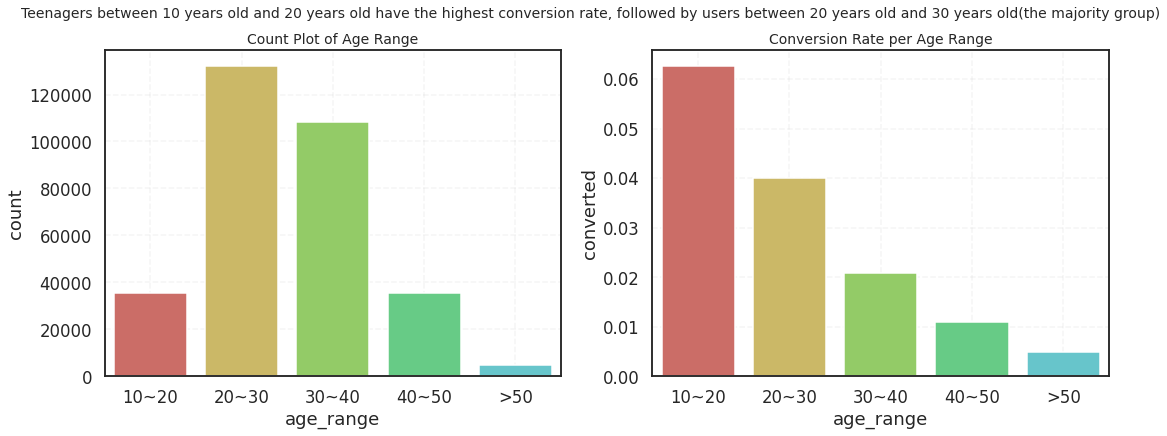

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='age_range', data=data.sort_values(by = "age"),ax=axes[0],palette=sns.color_palette("hls", 8))
axes[0].set_title('Count Plot of Age Range', fontsize=14)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(x='age_range', y='converted', data=data.sort_values(by = "age"), ci=0, ax=axes[1],palette=sns.color_palette("hls", 8));
axes[1].set_title('Conversion Rate per Age Range', fontsize=14)
axes[1].grid(linestyle="--", alpha=0.2)

fig.suptitle("Teenagers between 10 years old and 20 years old have the highest conversion rate, \
followed by users between 20 years old and 30 years old(the majority group)", fontsize = 14)
plt.show()

### 3-2. New User
This variable demonstrate whether the user is a new user or repeat user

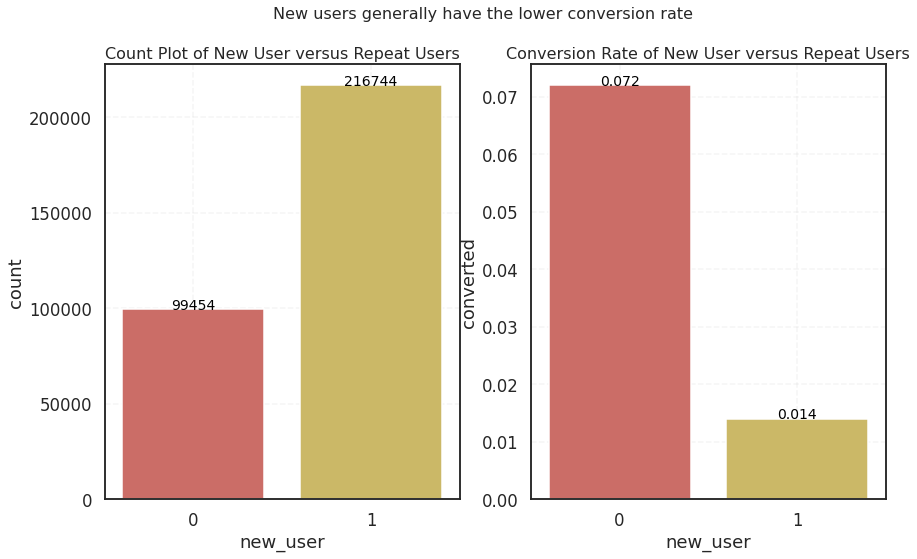

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.countplot(x='new_user', data=data,ax=axes[0],palette=sns.color_palette("hls", 8))
axes[0].set_title('Count Plot of New User versus Repeat Users', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)
group_values = data.groupby(by="new_user")["converted"].count().reset_index()
for index,row in group_values.iterrows():
    axes[0].text(row.new_user,row.converted,round(row.converted,4),color="black",ha="center",fontsize = 14)

sns.barplot(x='new_user', y='converted', data=data,ci=0,ax=axes[1],palette=sns.color_palette("hls", 8))
axes[1].set_title('Conversion Rate of New User versus Repeat Users', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)
group_values = data.groupby(by="new_user")["converted"].mean().reset_index()
for index,row in group_values.iterrows():
    axes[1].text(row.new_user,row.converted,round(row.converted,4),color="black",ha="center",fontsize = 14)

fig.suptitle("New users generally have the lower conversion rate", fontsize = 16)
plt.show()

### 3-3. Total Pages Visited
The total pages visited measures user engagement 

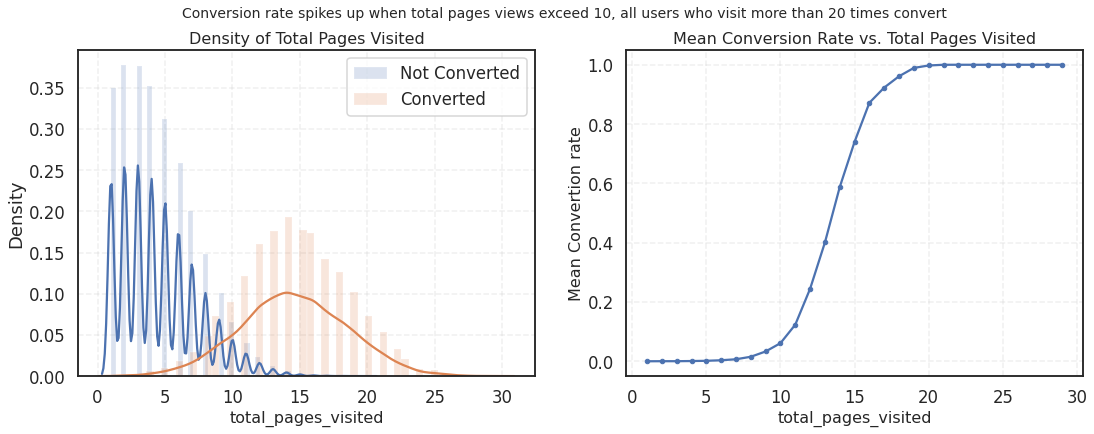

In [ ]:
# Visualization of different sources
grouped = data.groupby('total_pages_visited')["converted"].mean().reset_index()
hist_kws={'histtype': 'bar', 'alpha': 0.2}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'],
             label='Not Converted', ax=axes[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted', ax=axes[0], hist_kws=hist_kws)
axes[0].set_title('Density of Total Pages Visited', fontsize=16)
axes[0].set_xlabel('total_pages_visited',fontsize = 16)
axes[0].legend()
axes[0].grid(linestyle="--", alpha=0.3)

axes[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
axes[1].set_title('Mean Conversion Rate vs. Total Pages Visited', fontsize=16)
axes[1].set_xlabel('total_pages_visited',fontsize = 16)
axes[1].set_ylabel('Mean Convertion rate',fontsize = 16)
axes[1].grid(linestyle="--", alpha=0.3)

fig.suptitle("Conversion rate spikes up when total pages views exceed 10, all users who visit more than 20 times convert", fontsize = 14)
plt.show()

### 3-4. Country
This categorical variable depicts the geographic distribution of our website users

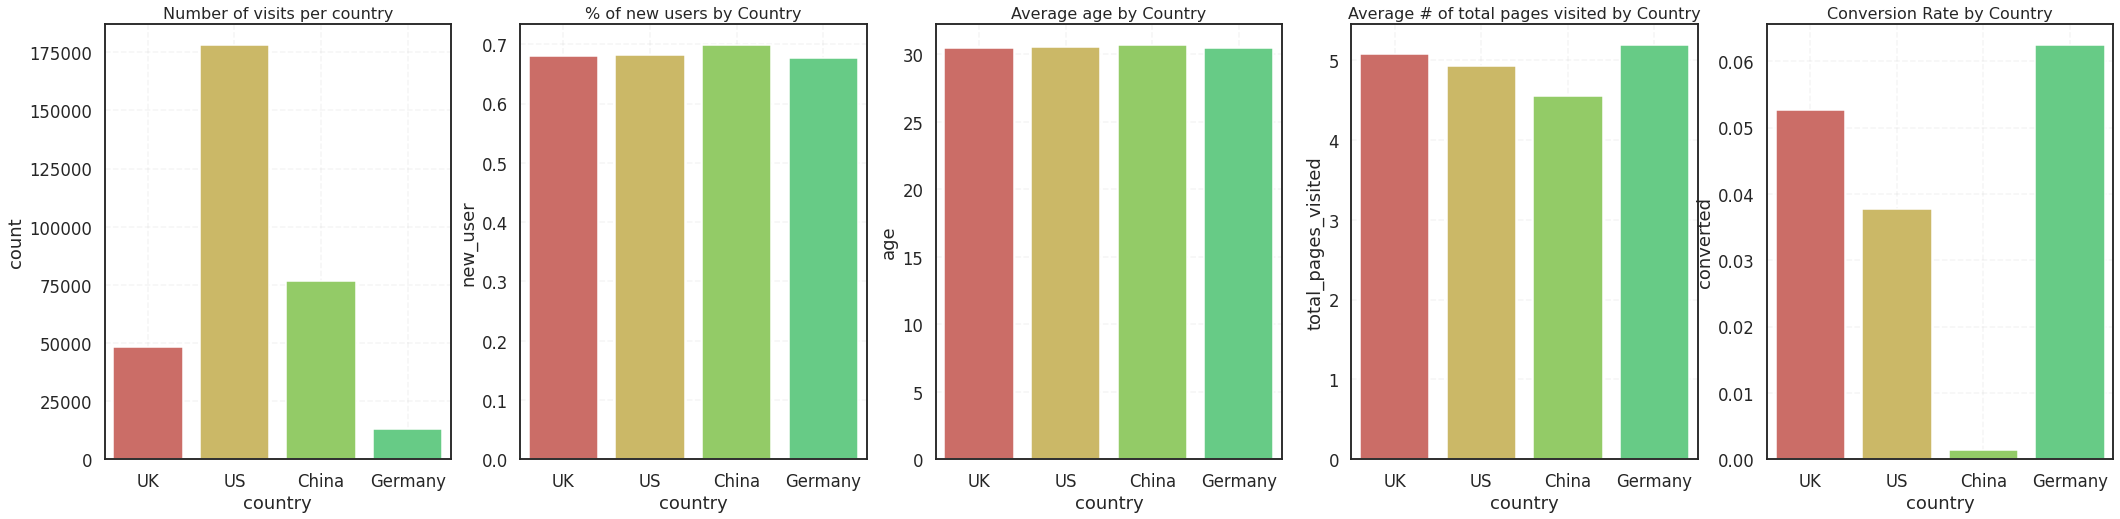

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(36, 8))
sns.countplot(x='country', data=data, ax=axes[0],palette=sns.color_palette("hls", 8))
axes[0].set_title('Number of visits per country', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(x='country', y='new_user', data=data,ci=0,ax=axes[1],palette=sns.color_palette("hls", 8))
axes[1].set_title('% of new users by Country', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)

sns.barplot(x='country', y='age', data=data,ci=0,ax=axes[2],palette=sns.color_palette("hls", 8))
axes[2].set_title('Average age by Country', fontsize=16)
axes[2].grid(linestyle="--", alpha=0.2)

sns.barplot(x='country', y='total_pages_visited', data=data,ci=0,ax=axes[3],palette=sns.color_palette("hls", 8))
axes[3].set_title('Average # of total pages visited by Country', fontsize=16)
axes[3].grid(linestyle="--", alpha=0.2)

sns.barplot(x='country', y='converted', data=data,ci=0,ax=axes[4],palette=sns.color_palette("hls", 8))
axes[4].set_title('Conversion Rate by Country', fontsize=16)
axes[4].grid(linestyle="--", alpha=0.2)

plt.show()

### 3-5. Source
This categorical variable depicts the marketing channels of our website users

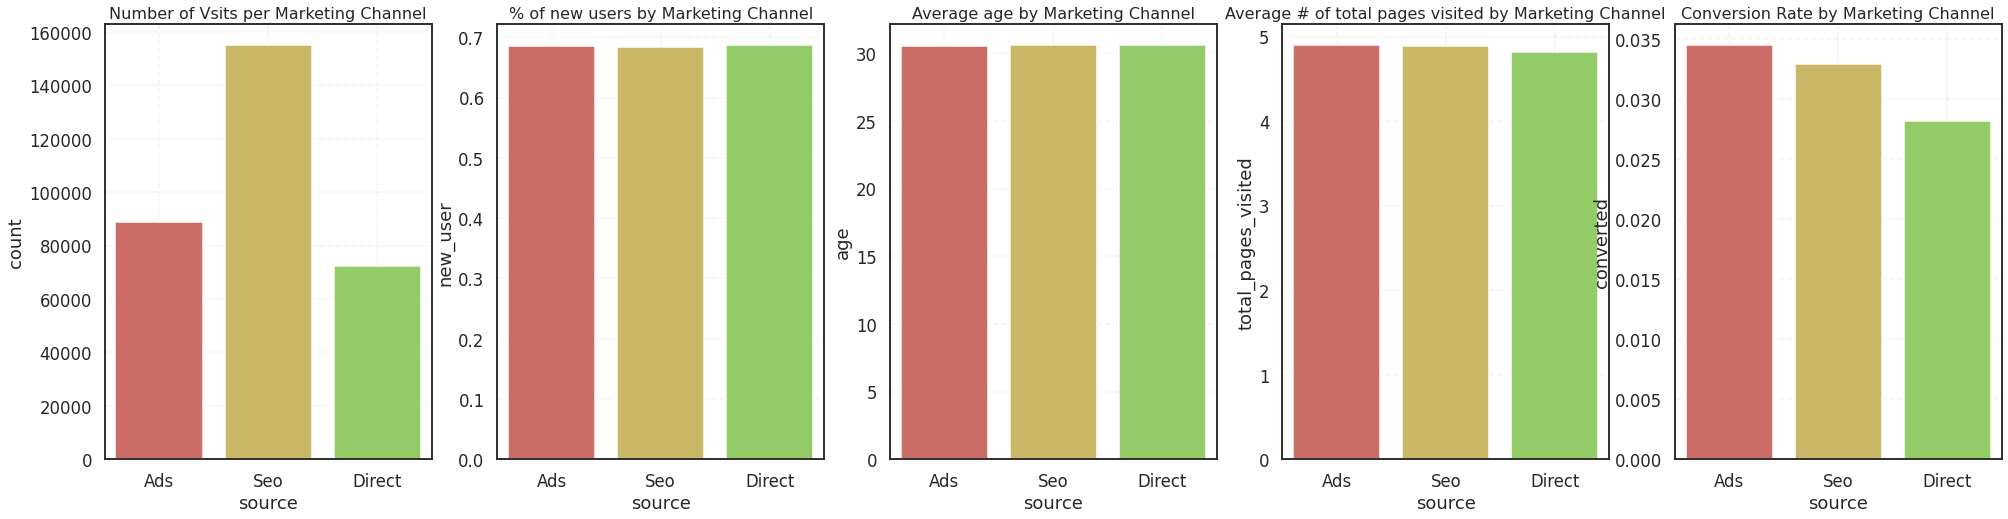

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(34,8))
sns.countplot(x='source', data=data, ax=axes[0],palette=sns.color_palette("hls", 8))
axes[0].set_title('Number of Vsits per Marketing Channel', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(x='source', y='new_user', data=data,ci=0,ax=axes[1],palette=sns.color_palette("hls", 8))
axes[1].set_title('% of new users by Marketing Channel', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)

sns.barplot(x='source', y='age', data=data,ci=0,ax=axes[2],palette=sns.color_palette("hls", 8))
axes[2].set_title('Average age by Marketing Channel', fontsize=16)
axes[2].grid(linestyle="--", alpha=0.2)

sns.barplot(x='source', y='total_pages_visited', data=data,ci=0,ax=axes[3],palette=sns.color_palette("hls", 8))
axes[3].set_title('Average # of total pages visited by Marketing Channel', fontsize=16)
axes[3].grid(linestyle="--", alpha=0.2)

sns.barplot(x='source', y='converted', data=data,ci=0,ax=axes[4],palette=sns.color_palette("hls", 8))
axes[4].set_title('Conversion Rate by Marketing Channel', fontsize=16)
axes[4].grid(linestyle="--", alpha=0.2)

plt.show()

# 4. Modeling

In [ ]:
# Let us take a brief overview
h2o.init()
h2o_data = H2OFrame(data)

# Encode the binary converted label as a factor
h2o_data['converted'] = h2o_data['converted'].asfactor()  

# Split the entire dataset into train and test
strat_split = h2o_data['converted'].stratified_split(test_frac=0.25, seed=2)
train = h2o_data[strat_split == 'train']
test = h2o_data[strat_split == 'test']

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprlsmpxww
  JVM stdout: /tmp/tmprlsmpxww/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmprlsmpxww/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 16 days
H2O_cluster_name:,H2O_from_python_unknownUser_d0z13f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
rf_clf = H2ORandomForestEstimator(nfolds = 3, seed = 1)

# We cannot specify the parameters in initializing the default model, when we also want to Gridsearch these parameters
params = {'ntrees': [30,50,60], 
        'max_depth': [3,5,6],
        'min_rows': [6,7,8]}
grid = H2OGridSearch(rf_clf, params, grid_id='depth_grid', search_criteria={'strategy': "Cartesian"})
#Train grid search
predictors = h2o_data.columns.remove("converted")
response = "converted"
grid.train(x=predictors, 
      y=response,
      training_frame = train)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [ ]:
sorted_grid = grid.get_grid(sort_by='auc',decreasing=True)
# Grab the top distributed random forest model, chosen by validation AUC
best_drf_model = sorted_grid.models[0]

In [ ]:
# Getting DRF model variable importances
var_imp = pd.DataFrame(best_drf_model.varimp(),columns = ["variable", "relative_importance",	"scaled_importance",	"percentage"])
var_imp.set_index("variable")

,relative_importance,scaled_importance,percentage
variable,,,
total_pages_visited,169907.859375,1.000000,0.908882
new_user,8188.158203,0.048192,0.043801
country,5233.955078,0.030805,0.027998
age,2180.867432,0.012836,0.011666
age_range,1362.763794,0.008021,0.007290
source,68.049332,0.000401,0.000364


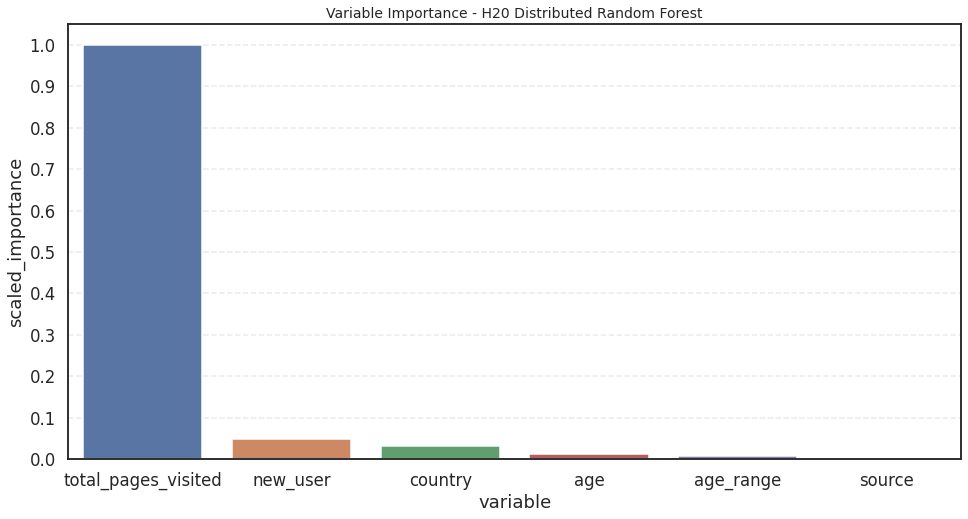

In [ ]:
# Getting DRF model variable importance PLOT
fig = plt.figure(figsize = (16,8))
imp = sns.barplot(var_imp.variable, var_imp.scaled_importance)
plt.title("Variable Importance - H20 Distributed Random Forest", fontsize = 14)
plt.yticks([i/10 for i in range(11)])
plt.grid(axis = "y", linestyle="--", alpha=0.4)
#for index,row in var_imp.iterrows():
 #   imp.text(index,row.scaled_importance,round(row.scaled_importance,4),color="black",ha="center",fontsize = 12)
plt.show()

In [ ]:
# Make predictions and check the AUC
test_true = test.as_data_frame()['converted'].values
test_pred = best_drf_model.predict(test).as_data_frame()['p1'].values

print(f"AUC of prediction on test dataset: {round(best_drf_model.model_performance(test).auc(),4)}")
print(f"AUC of cross-validated holdout predictions: {round(best_drf_model.auc(xval=True),4)}")


drf prediction progress: |████████████████████████████████████████████████| 100%
AUC of prediction on test dataset: 0.9773
AUC of cross-validated holdout predictions: 0.9795


In [ ]:
# F1-score = 2 * precision*recall / (precision+recall)
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int),target_names = ["not converted:0","converted:1"]))

                 precision    recall  f1-score   support

not converted:0       0.99      1.00      0.99     76500
    converted:1       0.85      0.69      0.76      2550

       accuracy                           0.99     79050
      macro avg       0.92      0.84      0.88     79050
   weighted avg       0.99      0.99      0.99     79050



In [ ]:
h2o.cluster().shutdown()